# Project Title: Solar Radiation Forecasting [notebook '04_Forecast_Out_of_DF.ipynb']

## Authors: Denys Herasymuk & Yaroslav Morozevych

In [1]:
import joblib
import matplotlib
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from datetime import timedelta
from keras.models import load_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# For Gooble Colab
# !pip install datapane==0.14.0

In [3]:
%matplotlib inline

alt.data_transformers.disable_max_rows()
alt.renderers.enable('html')

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

In [4]:
FORECAST_DAYS = 3
FORECAST_PERIOD = 24 * FORECAST_DAYS # 3 days
DECOMPOSED_SHIFT = FORECAST_PERIOD // 2 + (FORECAST_PERIOD // 2) % 24  # round to the closest number of days

FEATURES_LAGS = [24 * 2 + 24 * i for i in range(1, 4)]
RADIATION_LAGS = [24 * 2 + 24 * i for i in range(1, 4)]
RECENT_RADIATION_LAGS = [i for i in range(1, 6)]
MAX_DF_SHIFT = max(FEATURES_LAGS + RADIATION_LAGS)
HOME_DIR = '/content/drive/MyDrive/Colab Notebooks/UCU_ML_2022/UCU_Machine_Learning_Course_Project' # for Google Colab
N_FORECASTED_PERIODS = 1

## Init configurations

In [5]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Import the custom model
dir_path = HOME_DIR + '/results/'  # for Google Colab
# dir_path = os.getcwd() + '/'
reconstructed_model = load_model(dir_path + 'custom_model_v3.h5')

# Load MinMaxScaler.
# Since we used it on training, validation and testing datasets, it is better also use the same on the new coming data
delta_scaler = joblib.load(HOME_DIR + '/results/df_scaler_v3.pkl')

# Import trend and seasonality to use them during forecasting
multiplicative_decomposed_trend = pd.read_csv(HOME_DIR + '/results/multiplicative_decomposed_trend_v1.csv',
                                              header = 0, index_col = 0, squeeze = True)
multiplicative_decomposed_seasonal = pd.read_csv(HOME_DIR + '/results/multiplicative_decomposed_seasonal_v1.csv',
                                                 header = 0, index_col = 0, squeeze = True)

# For Google Colab here is path to dataset on Google Drive
hourly_radiation_df = pd.read_csv(HOME_DIR + '/data/dataset1_HourlySolarRadiationProcessed_s3.csv')
# hourly_radiation_df = pd.read_csv(os.path.join("..", "data", "dataset1_HourlySolarRadiationProcessed.csv"))
hourly_radiation_df['Hourly_DateTime'] = pd.to_datetime(hourly_radiation_df['Hourly_DateTime'])
hourly_radiation_df.head()

,Hourly_DateTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,ZenithDeviation
0,2016-10-01 00:00:00,1.26,48.50,30.45,88.25,153.25,9.98,697.62
1,2016-10-01 01:00:00,1.27,50.42,30.44,98.92,145.18,8.06,644.50
2,2016-10-01 02:00:00,1.28,50.08,30.43,100.00,136.54,6.84,584.50
3,2016-10-01 03:00:00,1.27,50.17,30.43,100.00,132.10,5.34,524.50
4,2016-10-01 04:00:00,1.27,50.17,30.43,100.17,117.02,6.75,464.50


In [7]:
def get_extrapolated_trend(trend):
    """
    Extrapolate trend on FORECAST_PERIOD. Each time when we forecast for new delta,
    we extrapolate trend on longer period on + FORECAST_PERIOD than previously 
    """
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=3)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)

    predict_idx = np.array([trend.index[-1] + i for i in range(1, DECOMPOSED_SHIFT + N_FORECASTED_PERIODS * FORECAST_PERIOD + 1)])
    X_actual_and_forecast = np.concatenate((X, predict_idx[:, np.newaxis]))
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X_actual_and_forecast))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X_actual_and_forecast, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.title('Extrapolation of trend')
    plt.show()

    return polynomial_trend_prediction.flatten()


def extrapolate_seasonality(seasonality, num_periods):
    new_seasonality = pd.concat([seasonality, seasonality[:num_periods * 24]])
    new_seasonality.index = range(0, len(new_seasonality))
    return new_seasonality

In [8]:
def create_feature_df_for_delta(df, df_scaler):
    """
    Prepare dataframe of feature to train models

    :return: normalized feature numpy arrays
    """
    feature_lags = [24 * i for i in range(1, 4)]
    radiation_lags = [24 * i for i in range(1, 4)]
    recent_radiation_lags = [i for i in range(1, 6)]

    # Create dataframe of features with different lags
    feature_df = process_delta_data(df, feature_lags, radiation_lags, recent_radiation_lags)
    feature_df.reset_index(drop=True, inplace=True)

    # Since on validation we used features + target column to normalize, 
    # to save dataframe size to input to scaler we need to create a technical series 
    technical_df = pd.Series([1 for _ in range(feature_df.shape[0])])
    full_df = pd.concat([feature_df, technical_df], axis=1)
    scaled_full_df = df_scaler.transform(full_df)

    return scaled_full_df[:, :-1]


def reshape_for_model(model_name, dataset):
    if 'LSTM' in model_name or\
            'RNN' in model_name or\
            'Conv1d' in model_name:

        if 'LSTM' in model_name:
            # reshape input to be 3D [samples, features, timesteps]
            dataset = dataset.reshape((dataset.shape[0], 1, dataset.shape[1]))

        else:
            # reshape input to be 3D [samples, timesteps, features]
            dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1))

    return dataset


def reshape_test_set_for_model(model_name, test_X):
    if 'LSTM' in model_name or\
            'RNN' in model_name or\
            'Conv1d' in model_name:

        if 'LSTM' in model_name:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        else:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    return test_X


def test_model_with_transform(model, test_X, model_name, first_row_idx):
    """

    Use previous predicted value to construct our feature dataframe and use it for next value prediction.
    And do it for each value, which we need to forecast based on FORECAST_PERIOD
    """
    yhat = []

    test_X = reshape_test_set_for_model(model_name, test_X)

    # Take first row for which we start to forecast.
    # Note that first_row_idx param can be also not equal to zero,
    # for example, it can also be the last index in test_X
    test_row = test_X[first_row_idx]
    prod_lags = test_row[-len(RECENT_RADIATION_LAGS):]
    test_row = test_row.reshape((1, len(test_row)))
    test_row = reshape_for_model(model_name, test_row)
    for i in range(len(test_X)):
        yhat_one_pred = model.predict(test_row)
        yhat.append(yhat_one_pred[0])

        test_row = test_X[i]

        prod_lags = np.roll(prod_lags, 1)
        prod_lags[0] = yhat_one_pred
        new_test_row = np.concatenate((test_row[:-len(RECENT_RADIATION_LAGS)], prod_lags), axis=0)
        test_row = new_test_row.reshape((1, len(new_test_row)))
        test_row = reshape_for_model(model_name, test_row)

    yhat = np.array(yhat)
    yhat[yhat<0] = 0
    return yhat

In [9]:
def process_delta_data(df, features_lags, radiation_lags, recent_radiation_lags):
    """
    Create a feature dataframe, which will be used for training ML and DL models

    :return:  dataframe of features filtered from NaN rows, which we got as result of lags for different dataframe columns
    """
    features_df = df.copy()
    features_df.drop(['Year', 'Day',
                      'Month',  # we do not have data for the whole year, hence we need to drop 'Month' column
                      'Hour', 'Log_Radiation'], axis=1, inplace=True, errors='ignore')
    if 'Hourly_DateTime' in features_df.columns:
        features_df.drop(['Hourly_DateTime'], axis=1, inplace=True)

    # Choose features which has good correlation or good logic causation for solar radiation
    feature_columns = ['Temperature', 'Pressure', 'Humidity', 'ZenithDeviation',
                       'WindDirection(Degrees)', 'Speed']

    for feature_column_name in feature_columns:
        for lag in features_lags:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df[feature_column_name].values[:-lag]))
            features_df[f'{feature_column_name}_lag_{lag}'] = temp

    # Take radiation lags as one of the features
    # Notice that here lags are more than our target forecast period
    for lag in radiation_lags:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df['Radiation'].values[:-lag]))
        features_df[f'Radiation_lag_{lag}'] = temp

    # Take last values, which we forecasted, and use them as features also
    for lag in recent_radiation_lags:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df['Radiation'].values[:-lag]))
        features_df[f'Radiation_lag_{lag}'] = temp

    features_df.fillna(features_df.mean(), inplace=True)

    # And finally drop Radiation
    features_df.drop(feature_columns, axis=1, inplace=True)
    features_df.drop(['Radiation'], axis=1, inplace=True)

    return features_df[max(features_lags + radiation_lags):]

In [10]:
def predict_out_of_df(test_model, df_scaler, original_df, test_df, input_features_df,
                      forecast_datetime_range, model_name, debug_mode=False):
    full_df_X = create_feature_df_for_delta(test_df, df_scaler)

    # reshape input to be 3D [samples, timesteps, features]
    full_df_X = full_df_X.reshape((full_df_X.shape[0], full_df_X.shape[1], 1))

    yhat = test_model_with_transform(test_model, full_df_X, model_name, -1)
    full_df_X = full_df_X.reshape((full_df_X.shape[0], full_df_X.shape[1]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((full_df_X, yhat), axis=1)
    inv_yhat = df_scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    predicted_seasonality = extrapolate_seasonality(multiplicative_decomposed_seasonal, 3)[-FORECAST_PERIOD:]
    predicted_trend = get_extrapolated_trend(multiplicative_decomposed_trend)[-FORECAST_PERIOD:]

    if debug_mode:
      plt.plot(inv_yhat)
      plt.title('Model forecast plot for residuals')
      plt.show()

    model_prediction_initial_series = inv_yhat * predicted_trend * predicted_seasonality

    start_idx = original_df.shape[0]
    end_idx = start_idx + FORECAST_PERIOD

    # add + 1 to make consistent plot
    before_lag = 14 * 24
    plt.plot(original_df['Hourly_DateTime'][start_idx + 1 - before_lag: start_idx + 1],
             original_df['Radiation'][start_idx + 1 - before_lag: start_idx + 1], color='blue', label="Last days original radiation")
    plt.plot(forecast_datetime_range, model_prediction_initial_series, color='red', label="Forecast")
    plt.legend(loc='upper left')
    plt.title(f'Forecast on 3 days ahead')
    plt.grid(alpha=0.3)
    plt.show()


In [11]:
def forecast_for_delta(delta_features_path):
  global hourly_radiation_df, N_FORECASTED_PERIODS

  # Load feature df for the last 3 days.
  # Note that Radiation is one of columns in delta_features,
  # since we use values of Radiation for the last 3 days as features 
  delta_features = pd.read_csv(delta_features_path)
  delta_features['Hourly_DateTime'] = pd.to_datetime(delta_features['Hourly_DateTime'])
  forecast_datetime_range = delta_features['Hourly_DateTime'] + timedelta(days=FORECAST_DAYS)

  hourly_radiation_df = pd.concat([hourly_radiation_df, delta_features], axis=0)

  delta_features_extended = pd.concat([delta_features, delta_features])
  predict_out_of_df(reconstructed_model, delta_scaler, hourly_radiation_df,
                    delta_features_extended, delta_features,
                    forecast_datetime_range, model_name='Conv1d', debug_mode=False)
  N_FORECASTED_PERIODS += 1

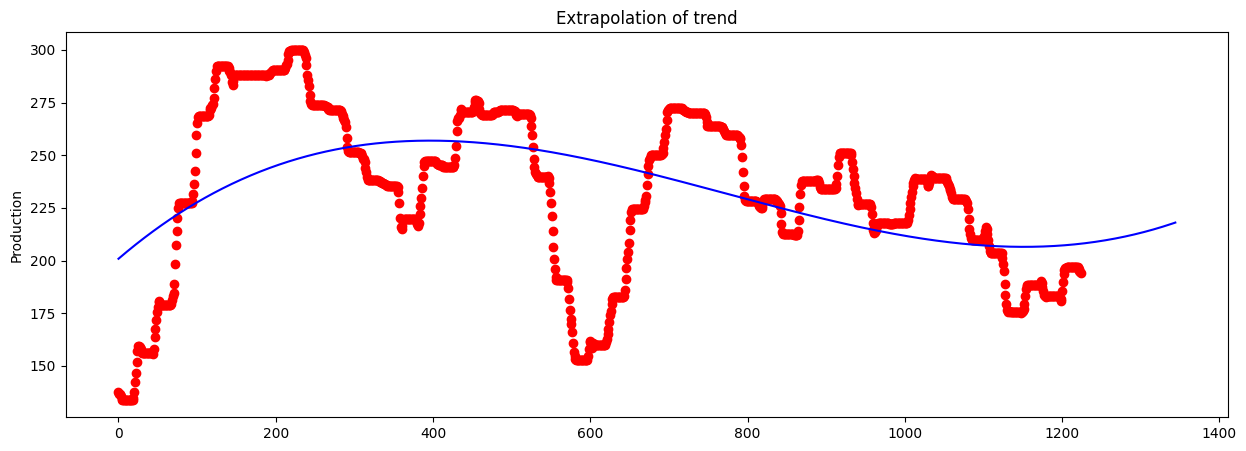

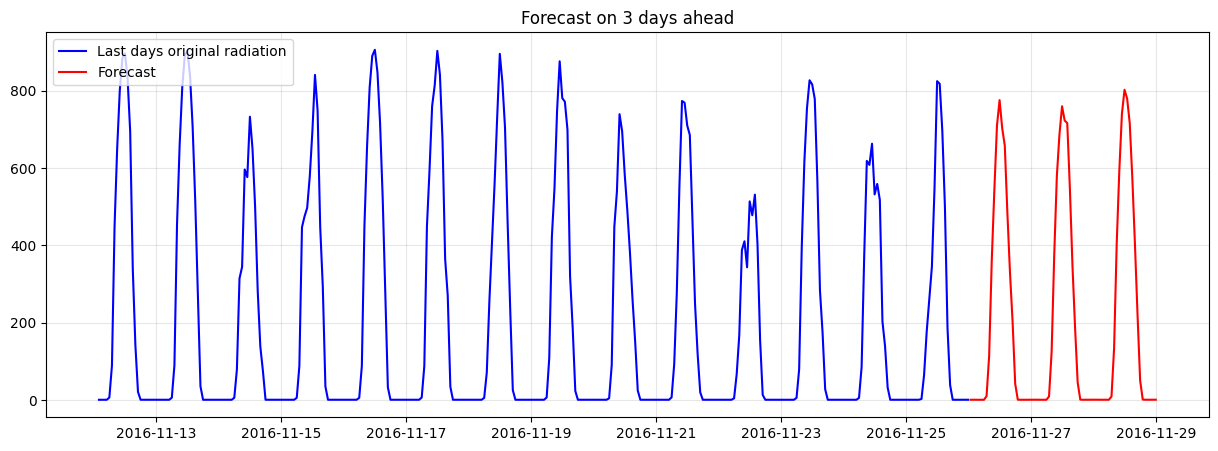

In [12]:
forecast_for_delta(delta_features_path=HOME_DIR + '/data/delta_period_1.csv')